In [1]:
from copypastelrm.utils.json_tools import read_jsonl_to_list, read_json, save_json, save_jsonl
from copypastelrm.metrics.HotpotQA import exact_match_score
from copypastelrm.metrics.utils import extract_answer_and_facts

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def plot_frequency(
    counts,
    x_values=None,
    xlabel=None,
    ylabel="Frequency",
    title=None,
    log=False,
    width=0.8,
    figsize=(6, 4),
    show=True,
):
    """
    Plot frequency/count data as a bar chart.

    Parameters
    ----------
    counts : array-like
        Frequency values, e.g. [3, 2, 4]
    x_values : array-like, optional
        X positions. Default: [0, 1, 2, ...]
    xlabel, ylabel, title : str, optional
        Axis labels and title.
    log : bool, default=False
        Use log scale on y-axis.
    width : float, default=0.8
        Bar width.
    figsize : tuple, default=(6, 4)
        Figure size.
    show : bool, default=True
        Whether to show the plot.
    """

    counts = np.asarray(counts)

    if x_values is None:
        x_values = np.arange(len(counts))
    else:
        x_values = np.asarray(x_values)

    plt.figure(figsize=figsize)
    plt.bar(x_values, counts, width=width)

    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    if title:
        plt.title(title)

    if log:
        plt.yscale("log")

    plt.tight_layout()

    if show:
        plt.show()

In [3]:
dir_root = "/mnt/lustre/DATA/longyongchao/CopyPasteLRM/pass_at_128/Qwen3-4B-Instruct-2507/resamples_-1/test"
paths = {
    # "faitheval": "/data/lyc/CopyPasteLRM/pass_at_42/Qwen3-4B-Instruct-2507/resamples_-1/test/faitheval-tpr_1.0-tpp_0.95-enable_thinking_False-tips_threshold_32-1766461616.jsonl",
    "hotpotqa": f"{dir_root}/hotpotqa-tpr_1.0-tpp_0.95-enable_thinking_False-tips_threshold_120-1766717370.jsonl",
    "2wikimultihopqa": f"{dir_root}/2wikimultihopqa-tpr_1.0-tpp_0.95-enable_thinking_False-tips_threshold_120-1766737933.jsonl",
    "multric": f"{dir_root}/multirc-tpr_1.0-tpp_0.95-enable_thinking_False-tips_threshold_120-1766737951.jsonl",
    # "musique": "/data/lyc/CopyPasteLRM/pass_at_42/Qwen3-4B-Instruct-2507/resamples_-1/test/musique-tpr_1.0-tpp_0.95-enable_thinking_False-tips_threshold_32-1766453865.jsonl",
    # "popqa": "/data/lyc/CopyPasteLRM/pass_at_42/Qwen3-4B-Instruct-2507/resamples_-1/test/popqa-tpr_1.0-tpp_0.95-enable_thinking_False-tips_threshold_32-1766406374.jsonl",
    # "pubmedqa": "/data/lyc/CopyPasteLRM/pass_at_42/Qwen3-4B-Instruct-2507/resamples_-1/test/pubmedqa-tpr_1.0-tpp_0.95-enable_thinking_False-tips_threshold_32-1766460369.jsonl",
    # "qasper": "/data/lyc/CopyPasteLRM/pass_at_42/Qwen3-4B-Instruct-2507/resamples_-1/test/qasper-tpr_1.0-tpp_0.95-enable_thinking_False-tips_threshold_32-1766428629.jsonl",
}

datas = {}
for key, path in paths.items():
    datas[key] = read_jsonl_to_list(path)

In [5]:
def compute_EM(data: list):
    is_correct_dict = {}
    for item in data:
        sample_id = item["id"]
        if "is_correct" not in item:
            continue
        is_correct = item["is_correct"]
        if sample_id not in is_correct_dict:
            is_correct_dict[sample_id] = is_correct
        else:
            if is_correct_dict[sample_id]:
                continue
            else:
                is_correct_dict[sample_id] = is_correct
    return sum(is_correct_dict.values()), len(is_correct_dict), is_correct_dict


for key, data in datas.items():
    em, total, is_correct_dict = compute_EM(data)
    print(key, em, total)

    pass_at_k_equal_0_subset_ids = [sample_id for sample_id, is_correct in is_correct_dict.items() if not is_correct]
    save_jsonl(pass_at_k_equal_0_subset_ids, paths[key].replace('.jsonl', 'pass_at_0_subset_ids.jsonl'))

hotpotqa 4485 7404
2wikimultihopqa 0 0
multric 370 949


[61851, 758, 410, 255, 155, 122, 94, 79, 60, 57, 50, 36, 32, 40, 36, 22, 22, 22, 18, 16, 30, 14, 13, 9, 10, 14, 18, 10, 9, 14, 13, 7, 10, 5, 8, 9, 9, 9, 6, 10, 10, 7, 7, 10, 6, 5, 2, 8, 11, 2, 5, 2, 8, 7, 4, 5, 8, 5, 4, 5, 5, 6, 6, 3, 3, 2, 3, 4, 7, 6, 1, 2, 2, 3, 3, 6, 3, 3, 0, 2, 3, 2, 5, 2, 2, 3, 3, 2, 4, 4, 1, 2, 2, 4, 1, 2, 1, 2, 4, 3, 2, 5, 1, 1, 3, 4, 4, 2, 2, 4, 1, 1, 2, 3, 0, 2, 0, 0, 0, 2618, 291, 105, 49, 21, 15, 15, 4, 3]


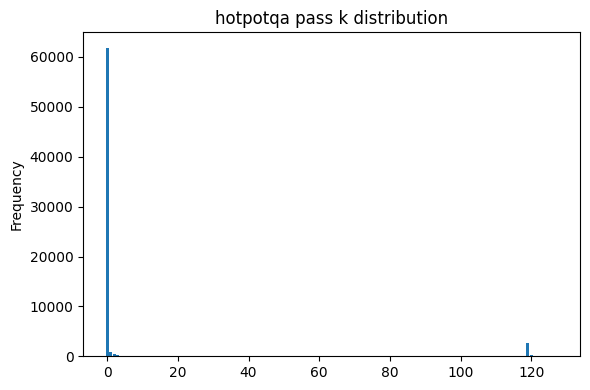

In [ ]:
def compute_pass_k_dirstribution(data: list, K: int = 42):
    distribution = [0] * K
    for item in data:
        if "is_correct" not in item or not item['is_correct']:
            continue
        attempt_idx = item['attempt_idx']
        distribution[attempt_idx - 1] += 1
    return distribution

for key, data in datas.items():
    distribution = compute_pass_k_dirstribution(data, K=128)
    print(distribution)
    plot_frequency(distribution, title=f'{key} pass k distribution')
        